# CNN: Celebrity Recognition

Neste projeto, construiremos uma rede neural capaz de reconhecer um artista através de uma foto.

Por limitações computacionais, utilizaremos um dataset reduzido e limitaremos o reconhecimento a 15 artistas:

* Aaron Taylor Johnson
* Adele
* Aaron Judge
* Alan Alda
* Adam Sandler
* Adriana Lima
* Adrianne Palicki
* Al Pacino
* Aaron Paul
* Alan Rickman
* Adriana Barraza
* Abigail Breslin
* Alan Arkin
* Adrien Brody
* Al Roker

Serão abordados as etapas de carregamento das imagens, pré-processamento, construção da rede neural, treinamento e teste.

### Para execução do script serão necessários os seguintes pacotes:

1. opencv-python
2. scikit-learn
3. keras
4. tensorflow
5. matplotlib
6. random
7. numpy
8. time

link para o dataset original (172GB): <a href="https://drive.google.com/drive/folders/0B5G8pYUQMNZnLTBVaENWUWdzR0E?usp=sharing">FULL DATASET</a>

link para os datasets usados no treino e teste do modelo (1,5GB): <a href="https://drive.google.com/open?id=15h5fahKkQnvvDvQMNc2dXIJMzELKAxgZ">SAMPLE</a>

# Preparação do dataset

Utilizamos os primeiros 15 nomes a partir da primeira parte do dataset original.

Selecionamos manualmente as imagens de cada artista, removendo imagens incorretas e evitando imagens de perfil (escolhemos angulos em que apareciam os dois olhos no rosto) ou imagens que haviam mais de uma pessoa, mesmo quando desfocada ou em segundo plano.  

In [1]:
# Começamos importando os pacotes e funções
import os
import random
import cv2
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from time import time

import matplotlib.pyplot as plt

import warnings

from imdb_utils import load_data, display_images_and_labels, display_label_images
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Vamos medir o tempo de execução do script. Criamos uma variável no inicio e no fim do projeto para calcular o tempo.
inicio = time()

# Variáveis 

Vamos definir todas as variáveis utilizadas no script que podem ser alteradas para buscar resultados melhores:

In [3]:
# Tamanho das imagens
size = 256

# Escala que as fotos são reduzidas para detecção das faces
scale = 1.1

# Vizinhos para detecção das faces
nn = 18

# Filtros da CNN
filters = 16

# Artistas presentes no dataset
celebrities = 15

# Script

## Primeira etapa:

### Importando as imagens e os rótulos

Inicialmente, utilizamos a função "load_data" para importar os dados de treino e teste.

Fizemos a primeira validação verificando o número de rótulos únicos e a quantidade de imagens importadas.
Depois, usamos as outras duas funções criadas no início do projeto "display_images_and_labels" e "display_label_images" afim de validar a integridade das informações.

Na primeira visualização, imprimimos uma imagem de cada artista com seu referido rótulo para verificar se as informações estavam alinhadas. Na segunda, imprimimos 5 imagens de um único artista com o mesmo intuito. 

É muito importante manter a validação dos processos enquanto realizamos alterações nos datasets. 

Como estamos trabalhando com duas listas separadas, onde a primera tem as informações das imagens, representadas por arrays numpy e a segunda contem os rótulos de cada imagem, com os nomes dos artistas, nós precisamos sempre garatir que as alterações estão sendo executadas da maneira correta e que os rótulos continuam alinhados com as imagens.

Por isso, nossa análise será feita de maneira visual com algumas imagens aleatórias durante o processo.

In [ ]:
# Carrega os datasets de treino e de teste
images, labels = load_data('datasets/treino')
images_test, labels_test = load_data('datasets/teste')

In [5]:
print(f"Labels Únicos: {len(set(labels))}\nTotal Imagens: {len(images)}")

Labels Únicos: 15
Total Imagens: 6473


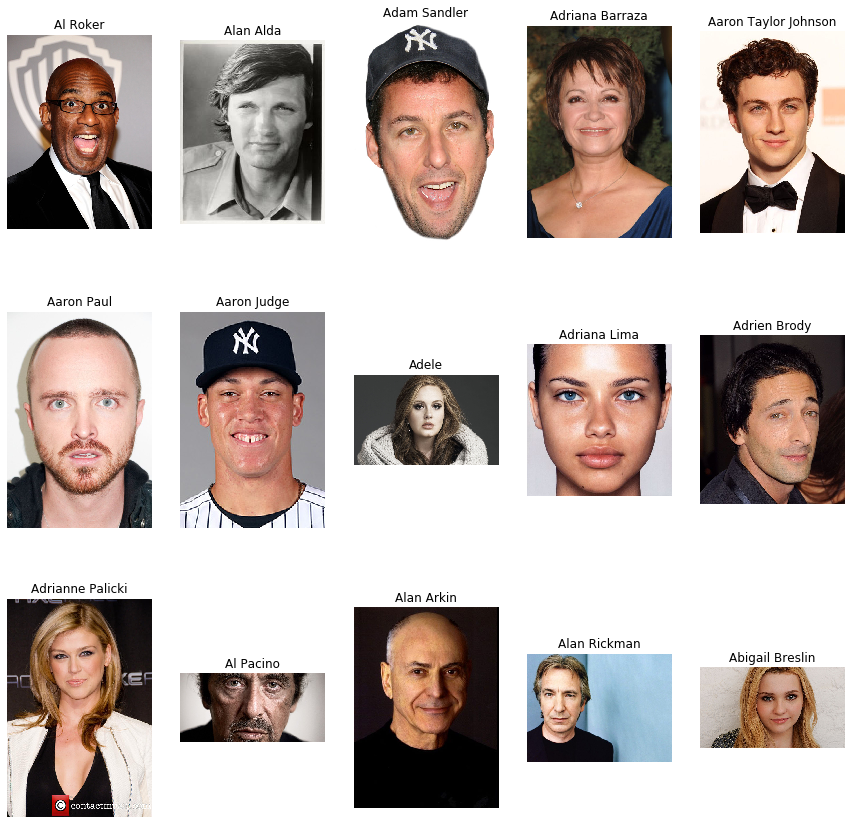

In [6]:
# Vamos usar a função para imprimir as imagens e seus rótulos afim de verificar se as operações ocorreram corretamente
display_images_and_labels(images, labels)

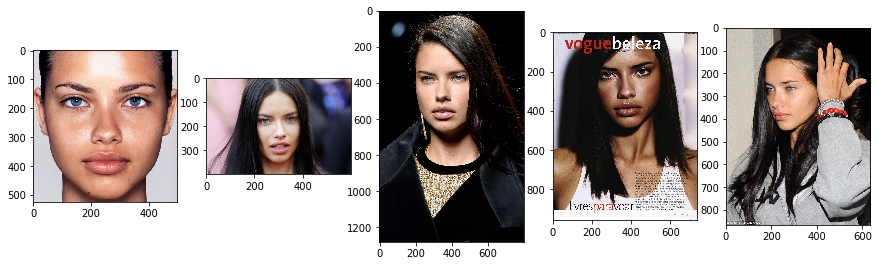

In [7]:
# Vamos verificar algumas imagens de um artista para verificar se todas representam ele mesmo e a variação de tamanho.
display_label_images(images, labels, 'Adriana Lima', limit=5, axis='on')

## Segunda etapa:

### Pré-processamento das imagens

Nosso projeto está focado no reconhecimento facial dos artistas. Dessa forma, nas etapas de pré-processamento precisamos alinhar os tamanhos, canais de cores (RGB/GRAY), escala do espaço de cores (Intensidade dos pixels) e recortar as faces, uma vez que é isso que estamos buscando ensinar ao modelo.

Inicialmente, vamos fazer algumas verificações para excluir as imagens que fogem ao padrão que buscamos. 

Começamos com um dataset de **6473** imagens.

Aplicamos o filtro para manter apenas as imagens que possuem 3 canais de cores:

1. Validamos o 'shape' com 3 dimensões
2. Validamos a posição '2' referente aos canais de cores como 3

Dessa forma, validamos o nosso dataset de treinamento com **6129** imagens.

In [8]:
# Verificando o tamanho de cada imagem e o range da intensidade dos pixels.
for image in images[:10]:
    print(f"shape: {image.shape}, min: {image.min()}, max: {image.max()}")

shape: (320, 213, 3), min: 0, max: 255
shape: (270, 180, 3), min: 0, max: 255
shape: (720, 1280, 3), min: 0, max: 255
shape: (399, 620, 3), min: 0, max: 255
shape: (608, 1080, 3), min: 0, max: 255
shape: (270, 180, 3), min: 0, max: 255
shape: (320, 213, 3), min: 0, max: 255
shape: (720, 1280, 3), min: 0, max: 255
shape: (906, 750, 3), min: 0, max: 255
shape: (2392, 3588, 3), min: 0, max: 255


In [9]:
# Realizando a primeira validação do formato das imagens.
indice1 = [i for i in range(len(images)) if len(images[i].shape) == 3]

In [10]:
# Aplicando os filtros às listas de imagens e labels
images2 = [images[indice] for indice in indice1]
labels2 = [labels[indice] for indice in indice1]

In [11]:
# Verificando se as listas continuam do mesmo tamanho
len(images2) == len(labels2)

True

In [12]:
# Verificando quantas imagens restaram após o filtro
len(images2)

6365

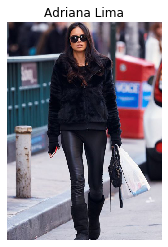

In [13]:
# Visualizando uma imagem aleatória e seu label para validar as alterações
rnd = random.randint(0, len(images2))
plt.title(f'{labels2[rnd]}')
plt.imshow(images2[rnd])
plt.axis('off')
plt.show()

In [14]:
# Realizando a segunda validação garantindo que as imagens possuem 3 canais de cor.
indice2 = [i for i in range(len(images2)) if images2[i].shape[2] == 3]

In [15]:
# Aplicando os filtros às listas de imagens e labels
images3 = [images2[indice] for indice in indice2]
labels3 = [labels2[indice] for indice in indice2]

In [16]:
# Verificando quantas imagens restaram após o filtro
len(images3)

6129

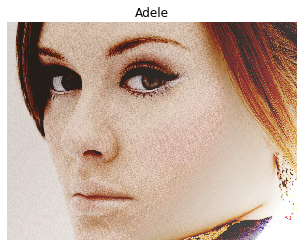

In [17]:
# Visualizando uma imagem aleatória e seu label para validar as alterações
rnd = random.randint(0, len(images2))
plt.title(f'{labels3[rnd]}')
plt.imshow(images3[rnd])
plt.axis('off')
plt.show()

In [18]:
# Após validação do formato das imagens, vamos realizar a conversão de todas elas para escala de cinza.
images_gray = [cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in images3]

### Crop das faces

Para identificar as faces nas imagens, vamos utilizar um modelo já treinado que acompanha o pacote opencv. 

Existem diversos modelos no pacote opencv, cada um focado em encontrar alguma caracteristica especifica nas imagens, sejam olhos, boca, nariz ou outros pontos chaves. 

Aqui, vamos usar o 'frontalface_default' que possue um vetor de recursos para encontrar faces frontais. 

Com o objeto instanciado, utilizaremos o método 'detectMultiScale' que percorre as imagens, alterando sua escala por fator determinado e verificando se existem faces ou não. Essa função retorna o ponto (x,y) onde se inicia o rosto, além das medidas de altura e largura. 

A partir desses dados, vamos percorrer cada imagem, recortar os rostos e convertê-las para o mesmo tamanho.

Se o modelo não for capaz de identificar a face na foto, ele retorna uma tupla vazia e dessa forma, descartaremos a imagem.

---

**Um ponto de atenção nessa etapa do processo é que o algoritmo de reconhecimento facial não é 100% confiável e também acaba indicando pontos errados como sendo um face. Nós temos que tentar reduzir o erro alterando os parametros da função, mas não existe um padrão a ser seguido. Infelizmente, não existe nenhuma métrica capaz de validar o resultado do crop e vamos tentar fazer uma análise visual com imagens aleatórias enquanto seguimos com as etapas. Teremos alguns erros, mas de maneira geral, o resultado foi satisfatório.** 

---

In [19]:
# Instanciando o objeto a partir do vetor de recursos com o modelo já treinado.
face_cascade = cv2.CascadeClassifier('models/face_cropper.xml')

In [20]:
# Verificando se o objeto foi instanciado corretamente
face_cascade.empty()

False

In [21]:
# Percorrendo as imagens e identificando a posição das faces.
faces = [face_cascade.detectMultiScale(image, scale, nn) for image in images_gray]

In [22]:
# Extraindo os dados da lista
x1, y1, w1, h1 = faces[0][0]

# Recortando a face
face1 = images_gray[0][y1:y1+h1, x1:x1+w1]

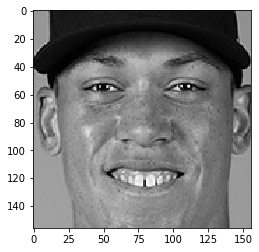

In [23]:
# Verificando se o recorte ocorreu como desejamos
plt.imshow(face1, cmap='gray')
plt.show()

In [24]:
# Listas para trazer as imagens e os labels das faces recortadas 
face_image = []
face_labels = []

# Loop para percorrer todas as fotos e recortar as faces. Caso a face não seja encontrada, descartamos a imagem.
for i in range(len(faces)):
    if faces[i] == ():
        continue
    x, y, w, h = faces[i][0]
    face_image.append(images_gray[i][y:y+h, x:x+w])
    face_labels.append(labels3[i])

In [25]:
# Verificando a quantidade de faces encontradas
len(face_image)

4338

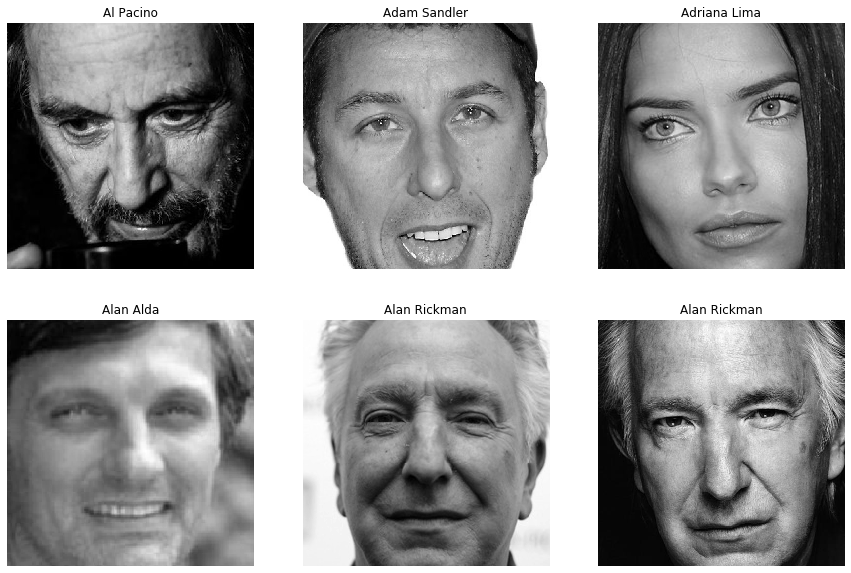

In [26]:
# Verificando algumas imagens aleatórias para validar o recorte dos rostos e seus respectivos rótulos.
plt.figure(figsize=(15,10))
for i in range(1, 7):
    plt.subplot(2 , 3, i)
    indice = random.randint(0, len(face_image))
    plt.title(f"{face_labels[indice]}")
    plt.axis('off')
    _ = plt.imshow(face_image[indice], cmap='gray')
plt.show()   

In [27]:
# Resize images
images256 = [skimage.transform.resize(image, (size, size)) for image in face_image]

As imagens a seguir foram geradas usando a função no arquivo `imdb_utils.py` que estava mapeada para uma imagem rgb.
É por isso que elas estão coloridas dessa forma.

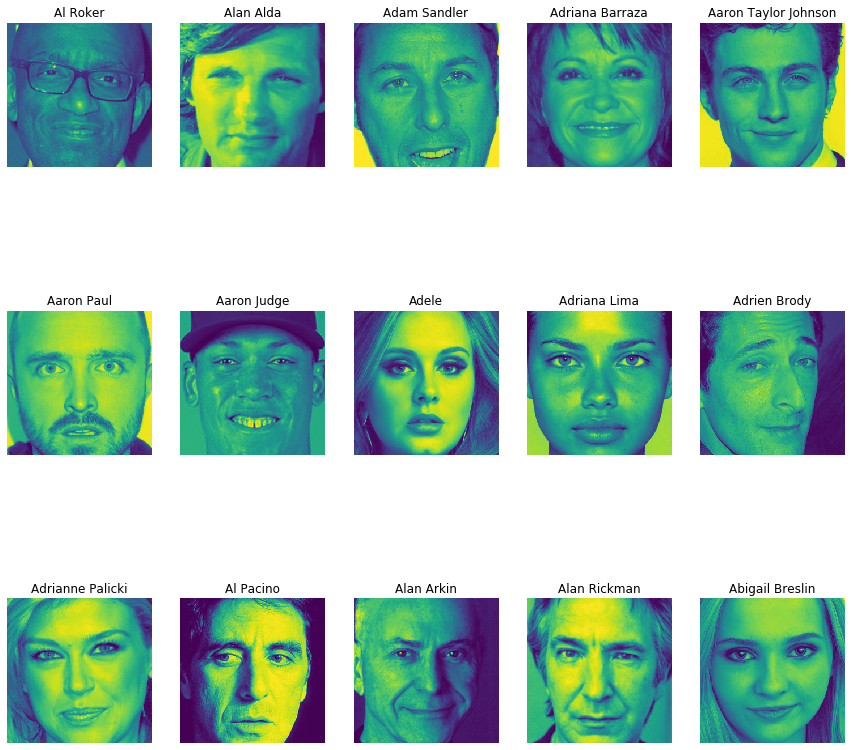

In [28]:
# Verificando uma imagem de cada artista após conversão para escala de cinza, crop das faces e resizing. 
display_images_and_labels(images256, face_labels)

In [29]:
# Verificando as informações após transformações.
for image in images256[:10]:
    print(f"shape: {image.shape}, min: {image.min()}, max: {image.max()}")

shape: (256, 256), min: 0.0005177217371336565, max: 0.9733551623774498
shape: (256, 256), min: 0.02821768966375688, max: 0.8901960784313725
shape: (256, 256), min: 0.049079296635646405, max: 1.0
shape: (256, 256), min: 0.02821768966375688, max: 0.8901960784313725
shape: (256, 256), min: 0.000283394607843193, max: 0.9935965893315362
shape: (256, 256), min: 0.01994485294117736, max: 0.9222430060891538
shape: (256, 256), min: 0.0, max: 0.9782500023935354
shape: (256, 256), min: 0.00032043457031254993, max: 0.942188397575827
shape: (256, 256), min: 0.006890540029489355, max: 0.9650054632448688
shape: (256, 256), min: 0.0006251914828431747, max: 0.992214128082874


In [30]:
# Validando rótulos e imagens
len(images256) == len(face_labels)

True

### Separação dos dados em treino e validação

Existem algumas funções que ajudam a seperar os dados do dataset em treino, teste e validação, como por exemplo a 'train_test_split' do sklearn. 

Vamos utilizar o keras para construir a arquitetura de nossa rede neural.

Na compilação do modelo, podemos indicar um percentual do dataset para ser direcionado como dados de validação, que serão utilizados no momento do treinamento para evitar overfitting. 

Nesse caso, optamos por realizar a separação manualmente porque tanto de uma forma como de outra, as dados não foram separados corretamente. Optamos por usar 70% dos dados em treino e 30% para validação.

Mais uma vez, usamos algumas imagens aleatórias durante o processo para validar a divisão, observando se as imagens estão corretas e alinhadas com os rótulos.

In [31]:
# Criando indice aleatório para divisão do dataset
indice_train = random.sample(range(len(images256)), int(len(images256)*0.7))

In [32]:
# Utilizando o indice para criar os dados de treino
X_train = np.array([images256[i] for i in indice_train])
y_train = np.array([face_labels[i] for i in indice_train])

In [33]:
# Utilizando o indice para criar os dados de validação
X_val = np.array([images256[i] for i in range(len(images256)) if i not in indice_train])
y_val = np.array([face_labels[i] for i in range(len(face_labels)) if i not in indice_train])

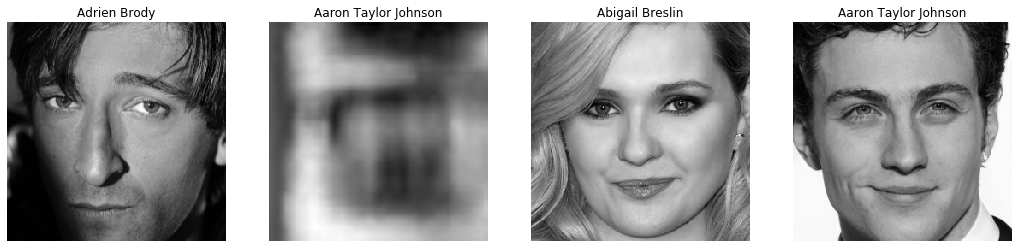

In [34]:
# Verificando aleatóriamente algumas imagens de treino
plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    indice = random.randint(1, len(X_train))
    plt.title(y_train[indice])
    plt.axis('off')
    plt.imshow(X_train[indice], cmap='gray')
plt.show()   

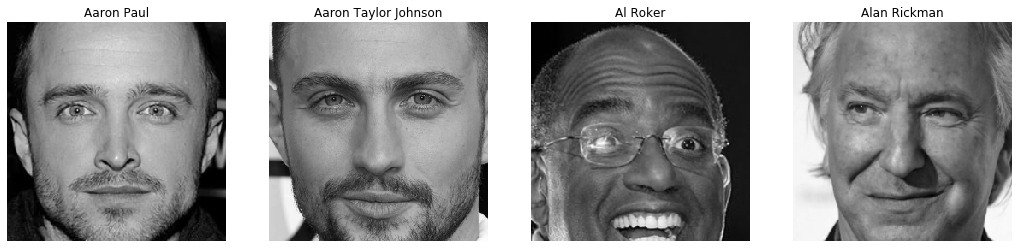

In [35]:
# Verificando aleatóriamente algumas imagens de validação
plt.figure(figsize=(18, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    indice = random.randint(1, len(X_val))
    plt.title(y_val[indice])
    plt.axis('off')
    plt.imshow(X_val[indice], cmap='gray')
plt.show()     

### Rede Neural

Utilizaremos uma arquitetura com 3 camadas de convolução, cada uma seguida por uma camada de pooling, onde escolhemos o valor máximo de cada filtro, além de 2 camadas densas e uma de dropout para auxiliar a reduzir problemas com overfitting.

As camadas de convolução aplicam filtros à cada parte da imagem e auxiliam na extração dos recursos.

Vamos aumentando o número de filtros a cada camada, diminuindo o tamanho das matrizes e buscando especificar detalhes de cada imagem para ensinar ao modelo.

As camadas de pooling funcinam como um redutor de dimensionalidade, mantendo apenas as informações mais importantes.

Nossa camada de saída terá um vetor com o mesmo tamanho do total de rótulos e apresentará uma probabilidade referente à imagem pertecer àquele rótulo.

A resposta da rede será o rótulo com maior probabilidade associada à ele. 

Para isso, vamos transformar nossa lista de rótulos para um formato one hot encoded.
Também serão necessários algumas transformações no shape dos dados para adaptar cada ação que vamos realizar.

Vamos utilizar um processo de "EarlyStopping" para que o modelo encerre o treinamento no momento em que as métricas associadas aos dados de validação começarem a decair. 

In [36]:
# Função para adaptação dos rótulos no formato one hot encoded
from sklearn.preprocessing import OneHotEncoder

# Camadas de Convolução e Pooling
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Outras camadas
from tensorflow.keras.layers import Dropout, Flatten, Dense

# Modelo Sequencial
from tensorflow.keras.models import Sequential

# Monitaramento para encerrar o treinamento e evitar o overfitting
from tensorflow.keras.callbacks import EarlyStopping

In [37]:
# Criando o objeto
encoder = OneHotEncoder(sparse=False, categories='auto')

# Aplicando aos dados target. Assim, criamos um vetor one hot encoded para cada posição da lista.
y_train_onehot = encoder.fit_transform(y_train.reshape(len(y_train), 1))
y_val_onehot = encoder.fit_transform(y_val.reshape(len(y_val), 1))

In [38]:
# Verificando as transformações
X_train.shape

(3036, 256, 256)

In [39]:
# Verificando as transformações
y_train_onehot.shape

(3036, 15)

In [40]:
# Reshape para o formato aceitado pelas camadas de convolução
X_train = X_train.reshape(X_train.shape[0], size, size, 1)
X_val = X_val.reshape(X_val.shape[0], size, size, 1)

In [41]:
# Modelo CNN

# Definindo parada antecipada para evitar overfitting do modelo
# Usando como monitor a entropia cruzada nos dados de validação
# Encerramento do treinamento após 3 epochs sem evolução de ao menos 0.001.
stop = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

# Instanciando o modelo sequencial
model = Sequential()
# Primeira camada de convolução com 16 filtros e um kernel 2x2
model.add(Conv2D(filters = filters, kernel_size = 2, activation = 'relu', input_shape = (256, 256, 1)))
# Primeira camada de pooling trazendo o valor máximo a cada matriz quadrada de 4 pixels percorrendo toda a imagem.
model.add(MaxPooling2D(pool_size = 2))
# Segunda camada de convolução com 32 filtros e um kernel 2x2
model.add(Conv2D(filters = filters * 2, kernel_size = 2, activation = 'relu'))
# Segunda camada de pooling
model.add(MaxPooling2D(pool_size=2))
# Terceira camada de convolução com 64filtros e um kernel 2x2
model.add(Conv2D(filters = filters * 4, kernel_size = 2, activation = 'relu'))
# Terceira camada de pooling
model.add(MaxPooling2D(pool_size=2))
# Transformando a matriz em um vetor para input na primeira camada densa
model.add(Flatten())
# Primeira camada densa com 512 neurônios
model.add(Dense(512, activation = 'relu'))
# Segunda camada densa com 256 neurônios
model.add(Dense(256, activation = 'relu'))
# Camada de Dropout que desativa aleatóriamente 50% dos neurônios a cada passada.
# Esse processo força a rede à utilizar diferentes atributos para realizar as previsôes e melhora a generalização.
model.add(Dropout(0.5))
# Camada de saída com o número de posições igual ao número de rótulos para definir uma probabilidade associada a cada um deles.
model.add(Dense(celebrities, activation = 'softmax'))

# Compilando o modelo utilizando entropia cruzada como função de custo,
# Otimizador Adam
# Acurácia como métrica de acompanhamento.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinamento do modelo, atualizando os pesos a cada 32 passadas, usando 30% dos dados originais como validação
model.fit(X_train, y_train_onehot, epochs=250, callbacks=[stop], verbose=1, validation_data=(X_val, y_val_onehot), batch_size=32)

Train on 3036 samples, validate on 1302 samples
Epoch 1/250
3036/3036 [==============================] - 16s 5ms/sample - loss: 2.5605 - accuracy: 0.1630 - val_loss: 2.0001 - val_accuracy: 0.3280
Epoch 2/250
3036/3036 [==============================] - 10s 3ms/sample - loss: 1.6208 - accuracy: 0.4918 - val_loss: 1.2260 - val_accuracy: 0.6206
Epoch 3/250
3036/3036 [==============================] - 10s 3ms/sample - loss: 0.9360 - accuracy: 0.7121 - val_loss: 0.8438 - val_accuracy: 0.7504
Epoch 4/250
3036/3036 [==============================] - 10s 3ms/sample - loss: 0.5162 - accuracy: 0.8429 - val_loss: 0.6762 - val_accuracy: 0.8018
Epoch 5/250
3036/3036 [==============================] - 10s 3ms/sample - loss: 0.2547 - accuracy: 0.9252 - val_loss: 0.6906 - val_accuracy: 0.7942
Epoch 6/250
3036/3036 [==============================] - 10s 3ms/sample - loss: 0.1563 - accuracy: 0.9542 - val_loss: 0.7638 - val_accuracy: 0.8072
Epoch 7/250
3036/3036 [==============================] - 10s 3ms

In [42]:
# Visualizando um resumo da rede.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 255, 255, 16)      80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 61504)             0

In [43]:
# Transformando as imagens de teste
test_images_transformed, test_labels = transform_images(images_test, labels_test, size=size, nn=nn)

In [44]:
# Verificando as transformações
for image in test_images_transformed[:10]:
    print(f"shape: {image.shape}, min: {image.min()}, max: {image.max()}")

shape: (256, 256), min: 0.012484277463427569, max: 0.8390120861577054
shape: (256, 256), min: 0.11128339580461108, max: 0.6265801373650068
shape: (256, 256), min: 0.003783955293543387, max: 0.9891036987304686
shape: (256, 256), min: 0.0196078431372549, max: 0.9529411764705882
shape: (256, 256), min: 0.0, max: 0.9885806364171648
shape: (256, 256), min: 0.00392156862745098, max: 1.0
shape: (256, 256), min: 0.0, max: 0.9540715086693834
shape: (256, 256), min: 0.0, max: 0.6607517616421538
shape: (256, 256), min: 0.0018841911764706717, max: 0.7370607862285542
shape: (256, 256), min: 0.0, max: 0.9998132593491503


In [45]:
# Transformando o objeto para facilitar a manipulação.
X_test = np.array(test_images_transformed)

In [46]:
# Verificando o shape
X_test.shape

(53, 256, 256)

In [47]:
# Transformando o shape para realizar as previsões
X_test2 = np.expand_dims(X_test, axis=4)

A Previsão foi de "Adele" com 100.00% de certeza e correto era "Adele".


A imagem de teste foi:


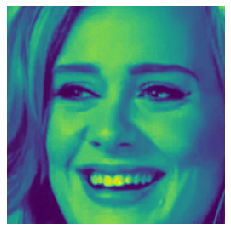

In [49]:
# Selecionando uma imagem aleatória para realizar a previsão e trazer algumas informações sobre o modelo.
indice2 = random.randint(0, len(X_test)-1)

# Previsão do modelo
predicted = model.predict(X_test[indice2].reshape(1,size,size,1))

# Print das informações
print(f'A Previsão foi de "{encoder.inverse_transform(predicted)[0][0]}" com {np.max(predicted)*100:0.2f}% de certeza e correto era "{test_labels[indice2]}".' )
print('\n')
print('A imagem de teste foi:')

# Visualizando a imagem
plt.imshow(X_test[indice2], cmap='gray')
plt.axis('off')
plt.show()

In [50]:
# Verificando o shape
X_test2.shape

(53, 256, 256, 1)

In [51]:
# Prevendo todas as imagens de teste
predicitons = model.predict(X_test2)

In [52]:
# Criando lista com os labels para verificar as métricas de performance do modelo
predicitons_labels = [encoder.inverse_transform(predicted.reshape(1, -1)) for predicted in predicitons]
predicitons_labels = [predicitons_labels[i][0][0] for i in range(len(predicitons_labels))]

In [54]:
print(f'A acurácia nas imagens de teste foi de {accuracy_score(predicitons_labels, test_labels)*100:0.2f}%')

A acurácia nas imagens de teste foi de 94.34%


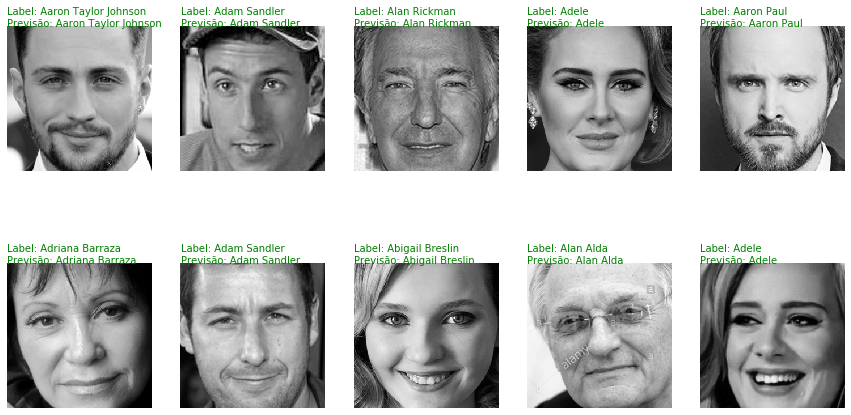

In [59]:
# Verificando algumas imagens de teste e os labels previstos
fig = plt.figure(figsize=(15, 8))
for i in range(10):
    indice3 = random.randint(1, len(predicitons_labels))
    truth = test_labels[indice3]
    prediction = predicitons_labels[indice3]
    plt.subplot(10/5, 5, i+1)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(0, 0, "Label: {0}\nPrevisão: {1}".format(truth, prediction), fontsize = 10, color = color)
    plt.imshow(X_test[indice3], cmap='gray')

In [56]:
model.save('face-recognition.hdf5')

In [57]:
# Finalizando a execução do pré processamento e treinamento do modelo.
# Calculando o tempo de execução.
fim = time()

print(f'\nO tempo de execução foi de {(fim - inicio)/60:.2f} minutos!!!\n')


O tempo de execução foi de 29.91 minutos!!!

